# Use Soft Actor-Critic with Auto $\alpha$ Tuning to Play LunarLander-v2

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import scipy.special
import pandas as pd
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import nn
from tensorflow import losses
from tensorflow import optimizers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

22:13:37 [INFO] env: <LunarLander<LunarLander-v2>>
22:13:37 [INFO] action_space: Discrete(4)
22:13:37 [INFO] observation_space: Box(-inf, inf, (8,), float32)
22:13:37 [INFO] reward_range: (-inf, inf)
22:13:37 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
22:13:37 [INFO] _max_episode_steps: 1000
22:13:37 [INFO] _elapsed_steps: None


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class SACAgent:
    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(100000)

        # create alpha
        self.target_entropy = -1.
        self.ln_alpha_tensor = tf.Variable(0., dtype=tf.float32)
        self.alpha_optimizer = optimizers.Adam(lr=0.0003)

        # create actor
        self.actor_net = self.build_net(
                hidden_sizes=[256, 256],
                output_size=self.action_n, output_activation=nn.softmax)

        # create Q critic
        self.q0_net = self.build_net(
                hidden_sizes=[256, 256],
                output_size=self.action_n)
        self.q1_net = self.build_net(
                hidden_sizes=[256, 256],
                output_size=self.action_n)

        # create V critic
        self.v_evaluate_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256])
        self.v_target_net = models.clone_model(self.v_evaluate_net)

    def build_net(self, hidden_sizes, output_size=1,
                activation=nn.relu, output_activation=None, input_size=None,
                loss=losses.mse, learning_rate=0.0003):
        model = keras.Sequential()
        for layer_idx, hidden_size in enumerate(hidden_sizes):
            kwargs = {'input_shape': (input_size,)} if \
                    layer_idx == 0 and input_size is not None else {}
            model.add(layers.Dense(units=hidden_size,
                    activation=activation, **kwargs))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, action, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, action, reward, next_state, done)
            if self.replayer.count >= 128:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        average_weights = [(1. - learning_rate) * t + learning_rate * e for t, e
                in zip(target_net.get_weights(), evaluate_net.get_weights())]
        target_net.set_weights(average_weights)

    def learn(self):
        states, actions, rewards, next_states, dones = self.replayer.sample(128)

        # train alpha
        all_probs = self.actor_net.predict(states)
        probs = np.take_along_axis(all_probs, actions[np.newaxis, :], axis=-1)
        ln_probs = np.log(probs.clip(1e-6, 1.))
        mean_ln_prob = ln_probs.mean()
        with tf.GradientTape() as tape:
            alpha_loss_tensor = -self.ln_alpha_tensor * (mean_ln_prob +
                    self.target_entropy)
        grads = tape.gradient(alpha_loss_tensor, [self.ln_alpha_tensor,])
        self.alpha_optimizer.apply_gradients(zip(grads, [self.ln_alpha_tensor,]))

        # train V critic
        q0s = self.q0_net.predict(states)
        q1s = self.q1_net.predict(states)
        q01s = np.minimum(q0s, q1s)
        pis = self.actor_net.predict(states)
        alpha = tf.exp(self.ln_alpha_tensor).numpy()
        entropic_q01s = pis * q01s - alpha * scipy.special.xlogy(pis, pis)
        v_targets = entropic_q01s.sum(axis=-1)
        self.v_evaluate_net.fit(states, v_targets, verbose=0)
        self.update_net(self.v_target_net, self.v_evaluate_net)

        # train Q critic
        next_vs = self.v_target_net.predict(next_states)
        q_targets = rewards[:, np.newaxis] + \
                self.gamma * (1. - dones[:, np.newaxis]) * next_vs
        np.put_along_axis(q0s, actions.reshape(-1, 1), q_targets, -1)
        np.put_along_axis(q1s, actions.reshape(-1, 1), q_targets, -1)
        self.q0_net.fit(states, q0s, verbose=0)
        self.q1_net.fit(states, q1s, verbose=0)

        # train actor
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        q0s_tensor = self.q0_net(state_tensor)
        with tf.GradientTape() as tape:
            probs_tensor = self.actor_net(state_tensor)
            alpha_tensor = tf.exp(self.ln_alpha_tensor)
            losses_tensor = alpha_tensor * tf.math.xlogy(probs_tensor,
                    probs_tensor) - probs_tensor * q0s_tensor
            actor_loss_tensor = tf.reduce_sum(losses_tensor, axis=-1)
        grads = tape.gradient(actor_loss_tensor,
                self.actor_net.trainable_variables)
        self.actor_net.optimizer.apply_gradients(zip(grads,
                self.actor_net.trainable_variables))


agent = SACAgent(env)

22:13:38 [INFO] ==== train ====
22:13:44 [DEBUG] train episode 0: reward = -75.95, steps = 112
22:14:29 [DEBUG] train episode 1: reward = -529.71, steps = 110
22:15:00 [DEBUG] train episode 2: reward = -131.70, steps = 70
22:15:26 [DEBUG] train episode 3: reward = -120.08, steps = 60
22:16:07 [DEBUG] train episode 4: reward = -435.99, steps = 97
22:16:56 [DEBUG] train episode 5: reward = -603.45, steps = 111
22:17:28 [DEBUG] train episode 6: reward = -151.64, steps = 68
22:18:08 [DEBUG] train episode 7: reward = -418.61, steps = 89
22:18:47 [DEBUG] train episode 8: reward = -234.14, steps = 83
22:19:25 [DEBUG] train episode 9: reward = -136.95, steps = 82
22:20:03 [DEBUG] train episode 10: reward = -124.34, steps = 84
22:20:53 [DEBUG] train episode 11: reward = -139.24, steps = 111
22:21:43 [DEBUG] train episode 12: reward = -193.62, steps = 110
22:22:07 [DEBUG] train episode 13: reward = -82.83, steps = 57
22:22:39 [DEBUG] train episode 14: reward = -220.59, steps = 72
22:23:29 [DEBUG

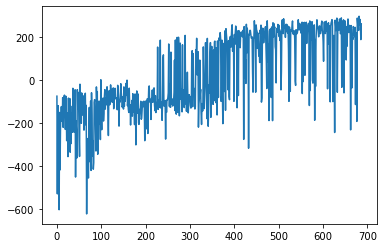

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 250:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()